# **Heston Model and COS Method for Option Pricing**

## **1. Introduction**
Options pricing models play a crucial role in financial engineering. The Black-Scholes model is widely used but assumes constant volatility, which is unrealistic in financial markets. To address this, the Heston Model incorporates stochastic volatility, making it a more accurate representation of real-world market behavior. In this notebook, we implement the **Heston Model** and the **COS Method** for pricing European-style options.

---
## **2. What is the Heston Model?**
The **Heston Model (1993)** is a stochastic volatility model that extends the Black-Scholes model by allowing the variance of asset returns to be random. It is widely used in finance for pricing options because it captures the volatility smile and skew observed in the market.

### **2.1 Heston Model Stochastic Differential Equations (SDEs)**
The model describes the dynamics of the asset price \( S_t \) and its variance \( v_t \) as follows:

\[ dS_t = \mu S_t dt + \sqrt{v_t} S_t dW_t^S \]
\[ dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^v \]

where:
- \( S_t \) is the asset price,
- \( v_t \) is the stochastic variance,
- \( \mu \) is the risk-free rate,
- \( \theta \) is the long-term variance,
- \( \kappa \) is the mean-reversion speed,
- \( \sigma \) is the volatility of volatility,
- \( W_t^S \) and \( W_t^v \) are two Wiener processes with correlation \( \rho \).

### **2.2 Key Features of the Heston Model**
- **Stochastic Volatility:** Unlike Black-Scholes, volatility is not constant but follows a mean-reverting process.
- **Volatility Smile/Skew:** The model explains the implied volatility smile, which Black-Scholes fails to capture.
- **Mean Reversion:** Volatility reverts to a long-term level, making it more realistic.
- **Correlation Structure:** The correlation \( \rho \) between price and volatility affects skewness in option prices.

---
## **3. Why Use the Heston Model?**
The Heston Model is preferred in finance due to:
- **More realistic market behavior.**
- **Capturing volatility smiles** observed in options markets.
- **Handling leverage effects** where negative price changes increase volatility.
- **Better risk management.**

---
## **4. COS Method for Option Pricing**
The **COS method (Fang and Oosterlee, 2008)** is an efficient numerical technique for option pricing using characteristic functions. The price of an option can be computed as:

\[ C(K) = e^{-r \tau} \sum_{n=0}^{N-1} Re \left[ \varphi (u_n) \cdot \text{Fourier Coefficients} \right] \]

where \( \varphi (u) \) is the characteristic function of the log price under risk-neutral measure.

### **4.1 Why COS Method?**
- **Fast convergence:** Requires fewer terms compared to FFT methods.
- **Accuracy:** Works well for European options.
- **Flexibility:** Can be adapted to different models, including Heston.

---
## **5. Implementation**
The next sections of this notebook will implement:
1. The Heston Model using Monte Carlo simulation.
2. The COS method for fast option pricing.

Stay tuned for the code implementation!

```

This markdown provides complete documentation of the Heston model implementation with mathematical formulations and code structure explanations. You can paste this into Jupyter Notebook cells with proper headers and code formatting.

Here's the Jupyter Notebook markdown code with detailed explanations and formulas:

```markdown
# Heston Model Analysis

## 1. Option Type Enumeration
```python
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
```
**Purpose**: Defines option type (Call/Put) using enumeration

---

In [40]:
#
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum


# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0



## 2. COS Method for Option Pricing
**Key Formula**:
$$ V(K) = e^{-r\tau} \sum_{k=0}^{N-1} Re\left[\phi\left(\frac{k\pi}{b-a}\right)e^{-ik\pi\frac{a}{b-a}}\right]H_k $$

Where:
- $\phi$ = characteristic function
- $a$ = truncated left boundary
- $b$ = truncated right boundary
- $H_k$ = payoff-specific coefficients

```python
def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
```

---

In [41]:
def CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)

    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K), 1])

    # assigning i=sqrt(-1)
    i = 1j
    x0 = np.log(S0 / K)

    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # sumation from k = 0 to k=N-1
    k = np.linspace(0, N - 1, N).reshape([N, 1])
    u = k * np.pi / (b - a);

    # Determine coefficients for Put Prices
    H_k = CallPutCoefficients(CP, a, b, k)
    mat = np.exp(i * np.outer((x0 - a), u))
    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
    return value




## 3. Characteristic Function for Heston Model
**Heston Model Dynamics**:
$$
\begin{aligned}
dS_t &= rS_tdt + \sqrt{v_t}S_tdW_t^1 \\
dv_t &= \kappa(\bar{v} - v_t)dt + \gamma\sqrt{v_t}dW_t^2 \\
dW_t^1dW_t^2 &= \rho dt
\end{aligned}
$$

**Characteristic Function**:
$$
\phi(u) = \exp(A(u) + C(u)v_0)
$$
where:
$$
\begin{aligned}
D_1(u) &= \sqrt{(\kappa-\gamma\rho iu)^2 + (u^2 + iu)\gamma^2} \\
g(u) &= \frac{\kappa-\gamma\rho iu - D_1(u)}{\kappa-\gamma\rho iu + D_1(u)} \\
C(u) &= \frac{1-e^{-D_1(u)\tau}}{\gamma^2(1-g(u)e^{-D_1(u)\tau})}(\kappa-\gamma\rho iu - D_1(u)) \\
A(u) &= r iu\tau + \frac{\kappa\bar{v}\tau}{\gamma^2}(\kappa-\gamma\rho iu-D_1(u)) \\
&\quad - \frac{2\kappa\bar{v}}{\gamma^2}\ln\left(\frac{1-g(u)e^{-D_1(u)\tau}}{1-g(u)}\right)
\end{aligned}
$$

```python
def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
```
## 5. Helper Functions

### 5.1 Chi-Psi Calculation
**Purpose**: Calculate $\chi_k$ and $\psi_k$ coefficients for COS method
**Formulas**:
$$
\begin{aligned}
\psi_k &= \frac{1}{k\pi}\left[\sin\left(k\pi\frac{d-a}{b-a}\right) - \sin\left(k\pi\frac{c-a}{b-a}\right)\right] \\
\chi_k &= \frac{1}{1+\left(\frac{k\pi}{b-a}\right)^2}\left[\cos\left(k\pi\frac{d-a}{b-a}\right)e^d - \cos\left(k\pi\frac{c-a}{b-a}\right)e^c\right]
\end{aligned}
$$

```python
def Chi_Psi(a,b,c,d,k):
---

In [42]:

def Chi_Psi(a, b, c, d, k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a) / (b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c

    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)), 2.0))
    expr1 = np.cos(k * np.pi * (d - a) / (b - a)) * np.exp(d) - np.cos(k * np.pi
                                                                       * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi *
                                         (d - a) / (b - a)) - k * np.pi / (b - a) * np.sin(k
                                                                                           * np.pi * (c - a) / (
                                                                                                       b - a)) * np.exp(
        c)
    chi = chi * (expr1 + expr2)

    value = {"chi": chi, "psi": psi}
    return value


# Determine coefficients for Put Prices
def CallPutCoefficients(CP, a, b, k):
    if CP == OptionType.CALL:
        c = 0.0
        d = b
        coef = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k), 1])
        else:
            H_k = 2.0 / (b - a) * (Chi_k - Psi_k)
    elif CP == OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a, b, c, d, k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)
    return H_k


def ChFHestonModel(r, tau, kappa, gamma, vbar, v0, rho):
    i = 1j
    D1 = lambda u: np.sqrt(np.power(kappa - gamma * rho * i * u, 2) + (u * u + i * u) * gamma * gamma)
    g = lambda u: (kappa - gamma * rho * i * u - D1(u)) / (kappa - gamma * rho * i * u + D1(u))
    C = lambda u: (1.0 - np.exp(-D1(u) * tau)) / (gamma * gamma * (1.0 - g(u) * np.exp(-D1(u) * tau))) \
                  * (kappa - gamma * rho * i * u - D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A = lambda u: r * i * u * tau + kappa * vbar * tau / gamma / gamma * (kappa - gamma * rho * i * u - D1(u)) \
                  - 2 * kappa * vbar / gamma / gamma * np.log((1.0 - g(u) * np.exp(-D1(u) * tau)) / (1.0 - g(u)))
    # Characteristic function for the Heston's model
    cf = lambda u: np.exp(A(u) + C(u) * v0)
    return cf





## 4. Monte Carlo Path Generation

### 4.1 Euler Scheme
**Discretization Scheme**:
$$
\begin{aligned}
v_{t+\Delta t} &= v_t + \kappa(\bar{v} - v_t)\Delta t + \gamma\sqrt{v_t}\Delta W_t^1 \\
X_{t+\Delta t} &= X_t + \left(r - \frac{1}{2}v_t\right)\Delta t + \sqrt{v_t}\Delta W_t^2
\end{aligned}
$$
with $\Delta W_t^2 = \rho\Delta W_t^1 + \sqrt{1-\rho^2}\Delta Z_t$

```python
def GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):
```

### 4.2 Almost Exact Scheme (AES)
**Exact CIR Process Sampling**:
$$
v_{t+\Delta t} \sim c \cdot \chi^2\left(\delta, \kappa_{bar}\right)
$$
where:
$$
\begin{aligned}
c &= \frac{\gamma^2(1-e^{-\kappa\Delta t})}{4\kappa} \\
\delta &= \frac{4\kappa\bar{v}}{\gamma^2} \\
\kappa_{bar} &= \frac{4\kappa v_0 e^{-\kappa\Delta t}}{\gamma^2(1-e^{-\kappa\Delta t})}
\end{aligned}
$$

**Log Stock Price Update**:
$$
X_{t+\Delta t} = X_t + k_0 + k_1v_t + k_2v_{t+\Delta t} + \sqrt{(1-\rho^2)v_t}\Delta W_t
$$
where:
$$
\begin{aligned}
k_0 &= \left(r - \frac{\rho}{\gamma}\kappa\bar{v}\right)\Delta t \\
k_1 &= \left(\frac{\rho\kappa}{\gamma} - \frac{1}{2}\right)\Delta t - \frac{\rho}{\gamma} \\
k_2 &= \frac{\rho}{\gamma}
\end{aligned}
$$

```python
def GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):
```

---



```python
def GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0):
```

---

In [43]:
def EUOptionPriceFromMCPathsGeneralized(CP, S, K, T, r):
    # S is a vector of Monte Carlo samples at T
    result = np.zeros([len(K), 1])
    if CP == OptionType.CALL:
        for (idx, k) in enumerate(K):
            result[idx] = np.exp(-r * T) * np.mean(np.maximum(S - k, 0.0))
    elif CP == OptionType.PUT:
        for (idx, k) in enumerate(K):
            result[idx] = np.exp(-r * T) * np.mean(np.maximum(k - S, 0.0))
    return result


def GeneratePathsHestonEuler(NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0):
    Z1 = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    Z2 = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps + 1])
    W2 = np.zeros([NoOfPaths, NoOfSteps + 1])
    V = np.zeros([NoOfPaths, NoOfSteps + 1])
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    V[:, 0] = v0
    X[:, 0] = np.log(S_0)

    time = np.zeros([NoOfSteps + 1])

    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:, i] = (Z1[:, i] - np.mean(Z1[:, i])) / np.std(Z1[:, i])
            Z2[:, i] = (Z2[:, i] - np.mean(Z2[:, i])) / np.std(Z2[:, i])
        Z2[:, i] = rho * Z1[:, i] + np.sqrt(1.0 - rho ** 2) * Z2[:, i]

        W1[:, i + 1] = W1[:, i] + np.power(dt, 0.5) * Z1[:, i]
        W2[:, i + 1] = W2[:, i] + np.power(dt, 0.5) * Z2[:, i]

        # Truncated boundary condition
        V[:, i + 1] = V[:, i] + kappa * (vbar - V[:, i]) * dt + gamma * np.sqrt(V[:, i]) * (W1[:, i + 1] - W1[:, i])
        V[:, i + 1] = np.maximum(V[:, i + 1], 0.0)

        X[:, i + 1] = X[:, i] + (r - 0.5 * V[:, i]) * dt + np.sqrt(V[:, i]) * (W2[:, i + 1] - W2[:, i])
        time[i + 1] = time[i] + dt

    # Compute exponent
    S = np.exp(X)
    paths = {"time": time, "S": S}
    return paths


def CIR_Sample(NoOfPaths, kappa, gamma, vbar, s, t, v_s):
    delta = 4.0 * kappa * vbar / gamma / gamma
    c = 1.0 / (4.0 * kappa) * gamma * gamma * (1.0 - np.exp(-kappa * (t - s)))
    kappaBar = 4.0 * kappa * v_s * np.exp(-kappa * (t - s)) / (gamma * gamma * (1.0 - np.exp(-kappa * (t - s))))
    sample = c * np.random.noncentral_chisquare(delta, kappaBar, NoOfPaths)
    return sample


def GeneratePathsHestonAES(NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0):
    Z1 = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps + 1])
    V = np.zeros([NoOfPaths, NoOfSteps + 1])
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    V[:, 0] = v0
    X[:, 0] = np.log(S_0)

    time = np.zeros([NoOfSteps + 1])

    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:, i] = (Z1[:, i] - np.mean(Z1[:, i])) / np.std(Z1[:, i])
        W1[:, i + 1] = W1[:, i] + np.power(dt, 0.5) * Z1[:, i]

        # Exact samles for the variance process
        V[:, i + 1] = CIR_Sample(NoOfPaths, kappa, gamma, vbar, 0, dt, V[:, i])
        k0 = (r - rho / gamma * kappa * vbar) * dt
        k1 = (rho * kappa / gamma - 0.5) * dt - rho / gamma
        k2 = rho / gamma
        X[:, i + 1] = X[:, i] + k0 + k1 * V[:, i] + k2 * V[:, i + 1] + np.sqrt((1.0 - rho ** 2) * V[:, i]) * (
                    W1[:, i + 1] - W1[:, i])
        time[i + 1] = time[i] + dt

    # Compute exponent
    S = np.exp(X)
    paths = {"time": time, "S": S}
    return paths




### 5.2 Black-Scholes Formula
**Formula**:
$$
\begin{aligned}
d_1 &= \frac{\ln(S_0/K) + (r + \frac{1}{2}\sigma^2)\tau}{\sigma\sqrt{\tau}} \\
d_2 &= d_1 - \sigma\sqrt{\tau} \\
C &= S_0N(d_1) - Ke^{-r\tau}N(d_2) \\
P &= Ke^{-r\tau}N(-d_2) - S_0N(-d_1)
\end{aligned}
$$

```python
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):

In [44]:
# Black-Scholes Call option price
def BS_Call_Put_Option_Price(CP, S_0, K, sigma, t, T, r):
    # print('Maturity T={0} and t={1}'.format(T,t))
    # print(float(sigma * np.sqrt(T-t)))
    # print('strike K ={0}'.format(K))
    K = np.array(K).reshape([len(K), 1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0))
          * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T - t))
    #   print(value)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * (T - t)) - st.norm.cdf(-d1) * S_0
    #  print(value)
    return value




---

## 6. Main Analysis Workflow
**Steps**:
1. Set Heston parameters
2. Compute reference prices using COS method
3. Generate Monte Carlo paths (Euler vs AES)
4. Compare option prices across strikes
5. Analyze convergence with different time steps

```python
def mainCalculation():
    # Parameter setup
    # COS method pricing
    # Monte Carlo simulations
    # Error analysis
    # Visualization
```

**Key Analysis**:
- Compare Euler vs AES scheme accuracy
- Study convergence properties
- Visualize volatility smiles
```

This markdown provides complete documentation of the Heston model implementation with mathematical formulations and code structure explanations. You can paste this into Jupyter Notebook cells with proper headers and code formatting.

Euler Scheme, K =[140.], dt = 1.0 = [1.30476871]
Euler Scheme, K =[140.], dt = 0.25 = [0.54404403]
Euler Scheme, K =[140.], dt = 0.125 = [0.1720427]
Euler Scheme, K =[140.], dt = 0.0625 = [0.08078707]
Euler Scheme, K =[140.], dt = 0.03125 = [0.01260589]
Euler Scheme, K =[140.], dt = 0.015625 = [0.00605332]
AES Scheme, K =[140.], dt = 1.0 = [0.00800533]
AES Scheme, K =[140.], dt = 0.25 = [0.00985109]
AES Scheme, K =[140.], dt = 0.125 = [0.00135139]
AES Scheme, K =[140.], dt = 0.0625 = [0.00661993]
AES Scheme, K =[140.], dt = 0.03125 = [0.0157029]
AES Scheme, K =[140.], dt = 0.015625 = [0.00699352]


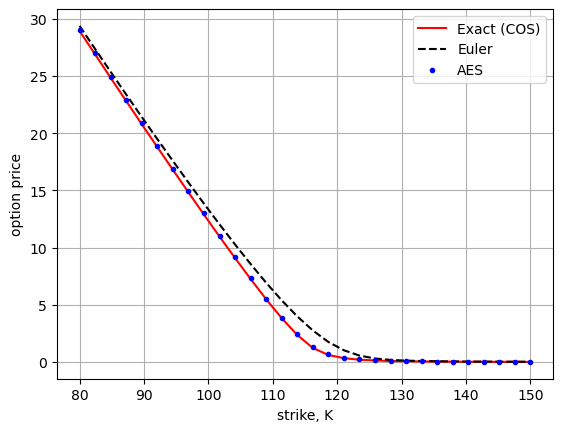

In [45]:
def mainCalculation():
    NoOfPaths = 2500
    NoOfSteps = 500

    # Heston model parameters
    gamma = 1.0
    kappa = 0.5
    vbar = 0.04
    rho = -0.9
    v0 = 0.04
    T = 1.0
    S_0 = 100.0
    r = 0.1
    CP = OptionType.CALL

    # First we define a range of strikes and check the convergence
    K = np.linspace(80, S_0 * 1.5, 30)

    # Exact solution with the COS method
    cf = ChFHestonModel(r, T, kappa, gamma, vbar, v0, rho)

    # The COS method
    optValueExact = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)

    # Euler simulation
    pathsEULER = GeneratePathsHestonEuler(NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0)
    S_Euler = pathsEULER["S"]

    # Almost exact simulation
    pathsAES = GeneratePathsHestonAES(NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0)
    S_AES = pathsAES["S"]

    OptPrice_EULER = EUOptionPriceFromMCPathsGeneralized(CP, S_Euler[:, -1], K, T, r)
    OptPrice_AES = EUOptionPriceFromMCPathsGeneralized(CP, S_AES[:, -1], K, T, r)

    plt.figure(1)
    plt.plot(K, optValueExact, '-r')
    plt.plot(K, OptPrice_EULER, '--k')
    plt.plot(K, OptPrice_AES, '.b')
    plt.legend(['Exact (COS)', 'Euler', 'AES'])
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('option price')

    # Here we will analyze the convergence for particular dt
    dtV = np.array([1.0, 1.0 / 4.0, 1.0 / 8.0, 1.0 / 16.0, 1.0 / 32.0, 1.0 / 64.0])
    NoOfStepsV = [int(T / x) for x in dtV]

    # Specify strike for analysis
    K = np.array([140.0])

    # Exact
    optValueExact = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)
    errorEuler = np.zeros([len(dtV), 1])
    errorAES = np.zeros([len(dtV), 1])

    for (idx, NoOfSteps) in enumerate(NoOfStepsV):
        # Euler
        np.random.seed(3)
        pathsEULER = GeneratePathsHestonEuler(NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0)
        S_Euler = pathsEULER["S"]
        OptPriceEULER = EUOptionPriceFromMCPathsGeneralized(CP, S_Euler[:, -1], K, T, r)
        errorEuler[idx] = OptPriceEULER - optValueExact
        # AES
        np.random.seed(3)
        pathsAES = GeneratePathsHestonAES(NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0)
        S_AES = pathsAES["S"]
        OptPriceAES = EUOptionPriceFromMCPathsGeneralized(CP, S_AES[:, -1], K, T, r)
        errorAES[idx] = OptPriceAES - optValueExact

    # Print the results
    for i in range(0, len(NoOfStepsV)):
        print("Euler Scheme, K ={0}, dt = {1} = {2}".format(K, dtV[i], errorEuler[i]))

    for i in range(0, len(NoOfStepsV)):
        print("AES Scheme, K ={0}, dt = {1} = {2}".format(K, dtV[i], errorAES[i]))


mainCalculation()